# Calculate SDOF response spectra
eqsig uses the efficient Nigam and Jennings (1968) algorithm to compute the spectral acceleration.
However, it does not enforce integration interval <= Period/20 if the ground motion time step is considerably larger
than this limit:

1. to avoid excessive computation
2. the record is probably missing frequency content that would
influence the response.

If a more accurate solution is needed for periods that are considerably lower than the recorded time step, you can 
change the limit on the ratio of ground motion time step over integration time step using the parameter `min_dt_ratio`, 
which defaults to 4.

This example demonstrates these aspects of the algorithm and other aspects of calculating the response.

In [7]:
import numpy as np
import eqsig
import matplotlib.pyplot as plt
from tests.conftest import TEST_DATA_DIR



## Array based input example
The majority of eqsig's functions have been implemented using numpy arrays, while it is recommended to 
use AccSignal object as an input, you can also use the array-based version of the function.


Text(0.5,0,'Period [s]')

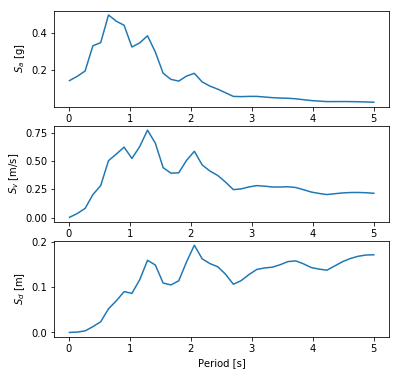

In [8]:
acc_record_filename = 'test_motion_dt0p01.txt'
acc = np.loadtxt(acc_record_filename, skiprows=2)
dt = 0.01

periods = np.linspace(0.01, 5, 40)
spectral_disp, spectral_velo, spectral_acc = eqsig.sdof.pseudo_response_spectra(acc, dt, periods, xi=0.05)

bf, sps = plt.subplots(nrows=3, figsize=(6, 6))

sps[0].plot(periods, spectral_acc / 9.8)
sps[1].plot(periods, spectral_velo)
sps[2].plot(periods, spectral_disp)

sps[0].set_ylabel('$S_a$ [g]')
sps[1].set_ylabel('$S_v$ [m/s]')
sps[2].set_ylabel('$S_d$ [m]')
sps[2].set_xlabel('Period [s]')


## Elastic response time series

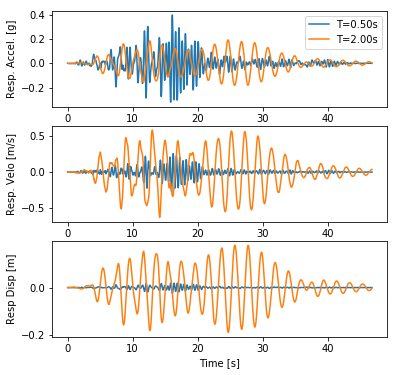

In [9]:
periods = np.array([0.5, 2.0])
response_disp, response_velo, response_accel = eqsig.sdof.response_series(acc, dt, periods, xi=0.05)

time = np.arange(0, len(acc)) * dt

bf, sps = plt.subplots(nrows=3, figsize=(6, 6))
sps[0].plot(time, response_accel[0] / 9.8, label='T=%.2fs' % periods[0])
sps[1].plot(time, response_velo[0])
sps[2].plot(time, response_disp[0])
sps[0].plot(time, response_accel[1] / 9.8, label='T=%.2fs' % periods[1])
sps[1].plot(time, response_velo[1])
sps[2].plot(time, response_disp[1])

sps[0].set_ylabel('Resp. Accel. [g]')
sps[1].set_ylabel('Resp. Velo [m/s]')
sps[2].set_ylabel('Resp Disp [m]')
sps[2].set_xlabel('Time [s]')
sps[0].legend()

## Validation against time-history analysis
### Load time history analysis solution

In [10]:

test_filename = 'test_motion_true_spectra_acc.csv'
data = np.loadtxt(TEST_DATA_DIR + test_filename, skiprows=1, delimiter=",")
periods = data[:, 0]
ss_s_a = data[:, 1]


## Load ground motion and compute response spectrum for same periods

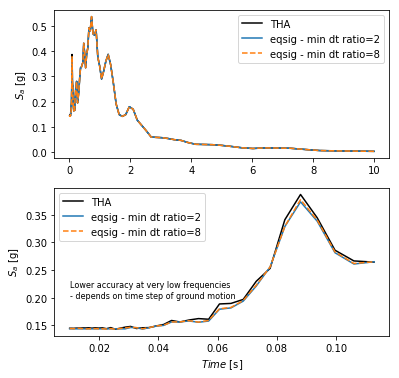

In [11]:
record_filename = 'test_motion_dt0p01.txt'
# loaded as an eqsig.AccSignal object
asig = eqsig.load_asig(record_filename)  # fast load of file for eqsig format

bf, sps = plt.subplots(nrows=2, figsize=(6, 6))
# plot THA
sps[0].plot(periods, ss_s_a, label="THA", c='k')
sps[1].plot(periods[:40], ss_s_a[:40], label="THA", c='k')

# plot response spectrum using default ratio on dt
asig.generate_response_spectrum(response_times=periods, xi=0.05, min_dt_ratio=2)
sps[0].plot(periods, asig.s_a / 9.81, label="eqsig - min dt ratio=2")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, label="eqsig - min dt ratio=2")

# Plot response spectrum using lower ratio on dt (slower computation)
asig.generate_response_spectrum(response_times=periods, xi=0.05, min_dt_ratio=8)
sps[0].plot(periods, asig.s_a / 9.81, ls='--', label="eqsig - min dt ratio=8")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, ls='--', label="eqsig - min dt ratio=8")

sps[1].text(0.01, 0.2, 'Lower accuracy at very low frequencies \n- depends on time step of ground motion', size=8)
sps[0].legend()
sps[1].legend()
sps[0].set_ylabel('$S_a$ [g]')
sps[1].set_ylabel('$S_a$ [g]')
sps[1].set_xlabel('$Time$ [s]')
plt.show()


## Compare to older version


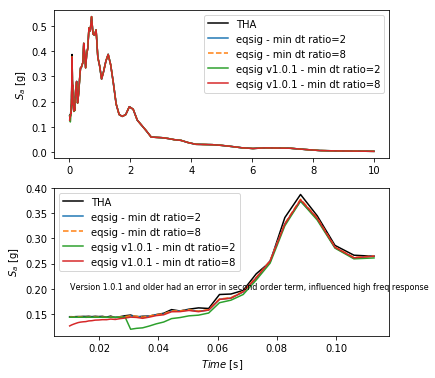

In [12]:
v1p0p1 = np.loadtxt('eqsig_v1p0p1.txt')
t_v1p0p1 = v1p0p1[:, 0]
sa_dt2_v1p0p1 = v1p0p1[:, 1]
sa_dt8_v1p0p1 = v1p0p1[:, 2]
bf, sps = plt.subplots(nrows=2, figsize=(6, 6))
# plot THA
sps[0].plot(periods, ss_s_a, label="THA", c='k')
sps[1].plot(periods[:40], ss_s_a[:40], label="THA", c='k')

# plot response spectrum using default ratio on dt
asig.generate_response_spectrum(response_times=periods, xi=0.05, min_dt_ratio=2)
sps[0].plot(periods, asig.s_a / 9.81, label="eqsig - min dt ratio=2")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, label="eqsig - min dt ratio=2")

# Plot response spectrum using lower ratio on dt (slower computation)
asig.generate_response_spectrum(response_times=periods, xi=0.05, min_dt_ratio=8)
sps[0].plot(periods, asig.s_a / 9.81, ls='--', label="eqsig - min dt ratio=8")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, ls='--', label="eqsig - min dt ratio=8")

sps[0].plot(periods, sa_dt2_v1p0p1 / 9.81, label="eqsig v1.0.1 - min dt ratio=2")
sps[1].plot(periods[:40], sa_dt2_v1p0p1[:40] / 9.81, label="eqsig v1.0.1 - min dt ratio=2")
sps[0].plot(periods, sa_dt8_v1p0p1 / 9.81, label="eqsig v1.0.1 - min dt ratio=8")
sps[1].plot(periods[:40], sa_dt8_v1p0p1[:40] / 9.81, label="eqsig v1.0.1 - min dt ratio=8")

sps[1].text(0.01, 0.2, 'Version 1.0.1 and older had an error in second order term, influenced high freq response', size=8)
sps[0].legend()
sps[1].legend()
sps[0].set_ylabel('$S_a$ [g]')
sps[1].set_ylabel('$S_a$ [g]')
sps[1].set_xlabel('$Time$ [s]')
plt.show()